In [1]:
import numpy as np 
import os
import cv2
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import model_from_yaml
import tensorflow as tf 

from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import cv2
import glob
import itertools
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split


from matplotlib import pyplot as plt
%matplotlib inline

from skimage.morphology import disk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import jaccard_similarity_score

## cpu configuration

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## the proposed network


In [3]:
'''
The implementation details with the explanation can be found on the paper. 
Please, read the paper first then see the source code.
'''
def SIMOCNN(nClasses, input_height, input_width):
    
    '''
    Load VGG16 from keras and initialize with the ImageNet. The output of the VGG16
    which is pool5 is used as input to all the sub-networks. This part of the network
    is responsible for the feature extraction which is so called convolution part 
    of the semantic segmentation CNN. 
    '''
    
    # defining the Input shape where channel 3 means RGB.  
    img_input = Input(shape=(input_height, input_width, 3)) 

    vgg_Base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_tensor = img_input) 
    
    '''
    To overcome the sub-sampling limitations  and  deconvolution  overlap, we  have
    employed two types of skip connections. First one is between the corresponding
    same dimensional feature map in both encoder and decoder which  has  ladder like
    structure and  it  is  inspired  from  U-Net. Second  one, so called FrG connect
    the very end layer of the decoder with the original image via stack of depthwise
    separable  convolution  without sub-sampling  to  produce  the  fully resolution
    feature map. Second skip connection is the compensatory of losing spacial 
    information dueto sub-sampling by concatenating the full resolution feature map.  
    In the presented SIMO-DCNN network, both  the  segmentation  and  regression  
    sub-networks  follow  our proposedencoder-decoder  networks  to  get  full  
    resolution  features  map.
    '''
    
    
    FrG = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(img_input)
    FrG = BatchNormalization()(FrG)
    
    FrG = SeparableConv2D(filters = 256,
                          kernel_size = (3, 3),
                          activation = 'relu', 
                          kernel_initializer='glorot_uniform', 
                          padding="same")(FrG)
    FrG = BatchNormalization()(FrG)
        
    FrG = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(FrG)
    FrG = BatchNormalization()(FrG)
    
    FrG = SeparableConv2D(filters = nClasses,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(FrG)
    FrG = BatchNormalization()(FrG)
    
    
    '''
    Decoding the encoded output to semantically project the discriminating features 
    of  lower  resolution learnt  by  the  encoder  onto  the  pixel space  of 
    higher  resolution  to  get a dense pixel wise classification.
    '''
    
    
    conv_14 = SeparableConv2D(filters = 1024, 
                            kernel_size = (3, 3), 
                            activation = 'relu', 
                            kernel_initializer='glorot_uniform', 
                            padding="same")(vgg_Base.output)
    conv_14 = BatchNormalization()(conv_14)


    conv_15 = SeparableConv2D(filters = 1024, 
                              kernel_size = (3, 3), 
                              activation = 'relu', 
                              kernel_initializer='glorot_uniform', 
                              padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)

    
    deconv_1 = UpSampling2D(size = (2, 2))(conv_15)
    deconv_1 = concatenate([vgg_Base.get_layer(name="block4_pool").output,
                            deconv_1], axis=-1)
    deconv_1 = SeparableConv2D(filters = 512, 
                               kernel_size = (3, 3), 
                               activation = 'relu', 
                               kernel_initializer='glorot_uniform', 
                               padding = "same")(deconv_1)
    deconv_1 = BatchNormalization()(deconv_1)


    deconv_2 = UpSampling2D(size = (2, 2))(deconv_1)
    deconv_2 = concatenate([vgg_Base.get_layer(name="block3_pool").output,
                            deconv_2], axis=-1)
    deconv_2 = SeparableConv2D(filters = 256,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(deconv_2)
    deconv_2 = BatchNormalization()(deconv_2)


    deconv_3 = UpSampling2D( size = (2, 2))(deconv_2)
    deconv_3 = concatenate([vgg_Base.get_layer(name="block2_pool").output,
                            deconv_3], axis=-1)
    deconv_3 = SeparableConv2D(filters = 128,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(deconv_3)
    kept = BatchNormalization()(deconv_3)
    
    
    

    '''
    DBRS blocks named as segmentation sub-network for semantic tissue or
    instrument pixels labelling to get semantic segmentation of the surgical tool.
    '''
    
    tool = UpSampling2D(size = (2, 2))(kept)
    tool = concatenate([vgg_Base.get_layer( name="block1_pool").output, 
                        tool], axis=-1)
    
    tool = SeparableConv2D(filters = 64,
                           kernel_size = (3, 3), 
                           activation = 'relu',
                           kernel_initializer='glorot_uniform',
                           padding = "same")(tool)
    tool = BatchNormalization()(tool)

    tool = UpSampling2D(size = (2, 2))(tool)
    tool = SeparableConv2D(filters = 64, 
                           kernel_size = (3, 3), 
                           activation = 'relu',
                           kernel_initializer='glorot_uniform', 
                           padding = "same")(tool)
    tool = BatchNormalization()(tool)

    tool = SeparableConv2D(filters = nClasses,
                           kernel_size = (1, 1),
                           activation = 'relu',
                           kernel_initializer='glorot_uniform',
                           padding = "same")(tool)
    tool = BatchNormalization()(tool)

    tool = concatenate([tool, FrG], axis=-1)

    tool = Conv2D(filters = 1,
                  kernel_size = 1,
                  activation = 'sigmoid',
                  name='tool')(tool)
 
    modeltool = Model(inputs = img_input, outputs = tool)    
    modeltool.load_weights('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/firststagemodel_putinthesis/pretrainedRobotic_editedFinal3LR1.h5')
    
    
    
    '''
    DBR blocks named as regression sub-network for mid-line feature of the surgical
    tool for pose estimation. 
    '''

    midline = UpSampling2D(size = (2, 2))(kept)
    midline = concatenate([vgg_Base.get_layer( name="block1_pool").output, 
                           midline], axis=-1)
    
    midline = SeparableConv2D(filters = 64,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(midline)
    midline = BatchNormalization()(midline)

    midline = UpSampling2D(size = (2, 2))(midline)
    midline = SeparableConv2D(filters = 64, 
                              kernel_size = (3, 3),activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(midline)
    midline = BatchNormalization()(midline)

    midline = SeparableConv2D(filters = nClasses, 
                              kernel_size = (1, 1),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(midline)
    midline = BatchNormalization()(midline)

    midline = concatenate([midline, FrG], axis=-1)

    midline = Conv2D(filters = 1,
                     kernel_size = 1,
                     activation = 'sigmoid',
                     name='midline')(midline)
 
    modelmidline = Model(inputs = img_input, outputs = midline)    
    modelmidline.load_weights('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/firststagemodel_putinthesis/pretrainedRobotic_editedFinal3LR1.h5')
 


    '''
    DBR blocks named as regression sub-network for tool-tip feature of the surgical
    tool for pose estimation. 
    '''

    tooltip = UpSampling2D(size = (2, 2))(kept)
    tooltip = concatenate([vgg_Base.get_layer( name="block1_pool").output,
                           tooltip], axis=-1)
    
    tooltip = SeparableConv2D(filters = 64,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(tooltip)
    tooltip = BatchNormalization()(tooltip)

    tooltip = UpSampling2D(size = (2, 2))(tooltip)
    tooltip = SeparableConv2D(filters = 64,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(tooltip)
    tooltip = BatchNormalization()(tooltip)

    tooltip = SeparableConv2D(filters = nClasses,
                              kernel_size = (1, 1),
                              activation = 'relu', 
                              kernel_initializer='glorot_uniform', 
                              padding = "same")(tooltip)
    tooltip = BatchNormalization()(tooltip)

    tooltip = concatenate([tooltip, FrG], axis=-1)

    tooltip = Conv2D(filters = 1,
                     kernel_size = 1,
                     activation = 'sigmoid',
                     name='tooltip')(tooltip)
 
    modeltooltip = Model(inputs = img_input, outputs = tooltip)    
    modeltooltip.load_weights('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/firststagemodel_putinthesis/pretrainedRobotic_editedFinal3LR1.h5')
    
    
    '''
    DBR blocks named as regression sub-network for Edge-line feature of the surgical
    tool for pose estimation. 
    '''

    edgeline = UpSampling2D(size = (2, 2))(kept)
    edgeline = concatenate([vgg_Base.get_layer( name="block1_pool").output,
                            edgeline], axis=-1)
    
    edgeline = SeparableConv2D(filters = 64,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(edgeline)
    edgeline = BatchNormalization()(edgeline)

    edgeline = UpSampling2D(size = (2, 2))(edgeline)
    edgeline = SeparableConv2D(filters = 64,
                               kernel_size = (3, 3),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(edgeline)
    edgeline = BatchNormalization()(edgeline)

    edgeline = SeparableConv2D(filters = nClasses,
                               kernel_size = (1, 1),
                               activation = 'relu',
                               kernel_initializer='glorot_uniform',
                               padding = "same")(edgeline)
    edgeline = BatchNormalization()(edgeline)

    edgeline = concatenate([edgeline, FrG], axis=-1)

    edgeline = Conv2D(filters = 1,
                      kernel_size = 1,
                      activation = 'sigmoid',name='edgeline')(edgeline)
 
    modeledgeline = Model(inputs = img_input, outputs = edgeline)    
    modeledgeline.load_weights('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/firststagemodel_putinthesis/pretrainedRobotic_editedFinal3LR1.h5')


    '''
    Detection sub-network for getting the tool flag that will indicate 
    either pose will estimate or not? 
    '''
    x = modeltool.get_layer('block5_conv3').output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax',name='detection')(x)
    
    modeldetection = Model(inputs=img_input, outputs=x)
    

    '''
    SIMO model is build by returning the multiple output as a list variable. 
    In the output prediction the sequence of the outputs are as follows:
    
    Output[0]= Predicted Probabilty map fo the surgical tool segmentation.
    Output[1]= Predicted Regression map for the mid-line of the surgical tool.
    Output[2]= Predicted Regression map for the tool-tip of the surgical tool.
    Output[3]= Predicted Regression map for the edge-line of the surgical tool.
    Output[4]= Predicted softmax probability of the tool detection.
    '''
      
    SIMO = Model(inputs = img_input, outputs = [modeltool.output,
                                              modelmidline.output,
                                              modeltooltip.output,
                                              modeledgeline.output,
                                              modeldetection.output])
    
#     for layer in SIMO.layers[:40]:
#         layer.trainable = False    

    return SIMO

## Data Generator 

In [4]:
def DataGenerator(data, batch_size): 
    '''
    This function is for the data generator for fit_generator training of the SIMO
    model. 
    Input Argument: 
          data = Is the numpy array having 6 column and N row. N is the number of 
          images as training/ testing sample. It can be pressented as below-
          
          orgImage | tool mask | edge-line | mid-line | tool-tip | label |
          ---------|-----------|-----------|----------|----------|-------|
          
          ---------|-----------|-----------|----------|----------|-------|
          batch_size = the number of samples that will perform forward-backward pass
                       in a single shot.
    Output Argument:
        Tuple of the true images and corresponding mask/ label for each types
        of sub-network. 
    '''
    
    img = np.array([i[0] for i in data]).reshape(-1,192,256,3)
    mask = np.array([i[1] for i in data]).reshape(-1,192,256,1)
    edge = np.array([i[2] for i in data]).reshape(-1,192,256,1)
    mid  = np.array([i[3] for i in data]).reshape(-1,192,256,1)
    tip = np.array([i[4] for i in data]).reshape(-1,192,256,1)
    label = np.array([i[5] for i in data])
    
    label=to_categorical(label, num_classes=2, dtype='float32')

    zipped = itertools.cycle( zip(img, mask, mid, edge, tip, label))
    

    while True:
        X = [] 
        Y = []
        Z = []
        A = []
        C = []   
        D = []
        for _ in range( batch_size):
            im , sg, sg_mid, sg_edge, sg_tip, lab = next(zipped)
            X.append(im)
            Y.append(sg)
            Z.append(sg_mid)
            A.append(sg_edge)
            C.append(sg_tip)
            D.append(lab)
            
        yield (np.array(X) , {'tool':np.array(Y),
                              'midline':np.array(Z),
                              'tooltip':np.array(C),
                              'edgeline':np.array(A),
                              'detection':np.array(D)})

## Loss Functions 

In [5]:
from tensorflow.keras import backend as K

def IoU(y_true, y_pred):
        
    ''' 
    The Intersection over Union (IoU) also referred to as the Jaccard index (JI),
    is essentially a method to quantify the percent overlap between the GT mask
    and prediction output. The IoU metric measures the number of pixels common 
    between the target and prediction masks divided by the total number of pixels
    present across both masks.
  
    Input Arguments: 
        y_true: True Labels of the 2D images so called ground truth (GT).
        y_pred: Predicted Labels of the 2D images so called Predicted/ segmented Mask.
        
    Output Arguments: 

        iou: The IoU between y_true and y_pred

    Author: Md. Kamrul Hasan, 
            Erasmus Scholar on Medical Imaging and Application (MAIA)
            E-mail: kamruleeekuet@gmail.com

    '''
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f)-intersection)


def IoU_loss(y_true, y_pred):
    return 1-IoU(y_true, y_pred)


def bce_IoU_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + IoU_loss(y_true, y_pred))


## Add extra data

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
import glob
from skimage.morphology import disk

#Setting directories Training
cDir = os.getcwd()

TI=glob.glob('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Extradata/PositiveImage/*.png')
TI.sort()
print(len(TI))

TM=glob.glob('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Extradata/MidLine/*.png')
TM.sort()
print(len(TM))

TMas=glob.glob('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Extradata/toolmask/*.png')
TMas.sort()
print(len(TMas))

TU=glob.glob('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Extradata/Edgeline1/*.png')
TU.sort()
print(len(TU))

TL=glob.glob('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Extradata/EdgeLine2/*.png')
TL.sort()
print(len(TL))

TT=glob.glob('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Extradata/Tooltip/*.png')
TT.sort()
print(len(TT))


training_data = []
XX=zip(TI, TM, TU, TL, TT, TMas)
i=0
kernel2=disk(4)
for pathorigP, pathmidP, pathupP, pathlowP, pathtipP, pathmasP in XX:
    ss = cv2.imread(pathorigP)
    img_pathorigP = cv2.resize(cv2.imread(pathorigP,-1),(256,192))
    img_pathorigP=img_pathorigP/img_pathorigP.max()
    #print(img_pathorigP.shape)
 
    img_pathmidP = cv2.resize(cv2.imread(pathmidP,-1),(256,192))
    img_pathmidP=img_pathmidP/img_pathmidP.max()
    img_pathmidP = np.expand_dims(img_pathmidP, axis=2)
    print(img_pathmidP.shape)

    img_pathupP = cv2.resize(cv2.imread(pathupP,-1),(256,192))
    img_pathupP=img_pathupP/img_pathupP.max()
    img_pathupP = np.expand_dims(img_pathupP, axis=2)
    print(img_pathupP.shape)
    
    img_pathlowP = cv2.resize(cv2.imread(pathlowP,-1),(256,192))
    img_pathlowP=img_pathlowP/img_pathlowP.max()
    img_pathlowP = np.expand_dims(img_pathlowP, axis=2)
    print(img_pathlowP.shape)
    
    img_pathmasP = cv2.resize(cv2.imread(pathmasP,-1),(256,192)) 
    img_pathmasP=img_pathmasP/img_pathmasP.max()
    img_pathmasP = img_pathmasP[:,:,0:1]
    print(img_pathmasP.shape)
    
    img_pathtipP = cv2.resize(cv2.imread(pathtipP,-1),(256,192))
    img_pathtipP = cv2.dilate(img_pathtipP,kernel2,iterations = 1)
    img_pathtipP=img_pathtipP/img_pathtipP.max()
    img_pathtipP = np.expand_dims(img_pathtipP, axis=2)
    print(img_pathtipP.shape)
    
    EdgeLine = img_pathupP + img_pathlowP
    EdgeLine=EdgeLine/EdgeLine.max()    
    #EdgeLine = np.expand_dims(EdgeLine, axis=2)
    print(EdgeLine.shape)
    #cv2.imwrite('/home/mahmoud/Desktop/image2.jpg',EdgeLine*255)
    
    #print(EdgeLine.dtype)
    #cv2.imwrite('/home/mahmoud/Desktop/image.png',np.uint8(EdgeLine))
     
    label=1


    training_data.append([np.array(img_pathorigP),
                          np.array(img_pathmasP),
                          np.array(EdgeLine),
                          np.array(img_pathmidP),
                          np.array(img_pathtipP),
                          np.array(label)])

extra_data = np.array(training_data)
print(extra_data.shape)


5
5
5
5
5
5
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(192, 256, 1)
(5, 6)


<ipython-input-6-0e36d1602a30>:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  extra_data = np.array(training_data)


## Train model 

In [7]:
CurrentDirectory=os.getcwd()


datatrain = np.load('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/DataFinal/training_data.npy',allow_pickle = True)
datatest = np.load('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/DataFinal/testing_data.npy',allow_pickle = True)

#x_train, x_valid = train_test_split(datatrain,test_size=0.20, shuffle= True)
#x_train = np.concatenate((x_train, extra_data))

#TrainGen = DataGenerator(data= x_train, batch_size=5)
#TestGen = DataGenerator(data= x_valid, batch_size=5)
datatrain = np.concatenate((datatrain, extra_data))

TrainGen = DataGenerator(data= datatrain, batch_size=5)
TestGen = DataGenerator(data= datatest, batch_size=5)
print(datatrain.shape)
#datatest = np.load('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/DataFinal/testing_data.npy',allow_pickle = True)


model = SIMOCNN(2, 192, 256)
#modelSavePath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/ModelLR_1/FinalModel.hdf5'


plot_model(model, show_shapes=True, to_file='Graph of ART-Net.png')
model.summary()

optim = Adadelta(learning_rate=1)

model.compile(optimizer = optim, 
              loss = {'tool':bce_IoU_loss,
                      'midline':'mean_squared_error',
                      'tooltip':'mean_squared_error',
                      'edgeline':'mean_squared_error',
                      'detection':'categorical_crossentropy',}, 
              metrics = {'tool': IoU,
                         'midline':'mae',
                         'tooltip':'mae',
                         'edgeline':'mae',
                         'detection': 'acc'})

checkpoint_path = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/FullTraining/ModelLR1/Checkpoint'
modelSavePath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/FullTraining/ModelLR1/full_testasval_nosplit_extradata_adaptiveLR1First_stage_with_LR1_new.h5'
    
model_checkpoint = [
tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,save_weights_only=True, save_freq = 'epoch' ),
tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, mode='min'), ## new_lr = lr * factor # 5
tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=60, mode='min', restore_best_weights=True),    
tf.keras.callbacks.CSVLogger('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/FullTraining/ModelLR1/full_testasval_nosplit_extradata_adaptiveLR1First_stage_with_LR1_new.csv'),
tf.keras.callbacks.TensorBoard(log_dir='/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/FullTraining/ModelLR1/logs',write_graph=True),
tf.keras.callbacks.TerminateOnNaN()]
        

#model_checkpoint = ModelCheckpoint('FineTunedmodel.hdf5', 
#                                   monitor='val_loss', 
#                                   verbose=1, 
#                                   save_best_only=True)





model_yaml = model.to_yaml()
with open('modelSaved.yaml', "w") as yaml_file:
    yaml_file.write(model_yaml)

history=model.fit_generator(TrainGen, 
                             steps_per_epoch=133, 
                             epochs=200,                  
                             verbose=1, 
                             validation_data= TestGen , 
                             validation_steps=31,
                             callbacks=[model_checkpoint])

model.save(modelSavePath)

(1329, 6)
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (

/home/mahmoud/anaconda3/envs/torchgpu/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
133/133 [==============================] - 246s 366ms/step - loss: 2.3118 - tool_loss: 1.1001 - midline_loss: 0.0269 - tooltip_loss: 0.0250 - edgeline_loss: 0.0317 - detection_loss: 1.1281 - tool_IoU: 0.3307 - midline_mae: 0.0315 - tooltip_mae: 0.0281 - edgeline_mae: 0.0389 - detection_acc: 0.5310 - val_loss: 1.8499 - val_tool_loss: 1.0048 - val_midline_loss: 0.0052 - val_tooltip_loss: 0.0022 - val_edgeline_loss: 0.0088 - val_detection_loss: 0.8288 - val_tool_IoU: 0.3133 - val_midline_mae: 0.0090 - val_tooltip_mae: 0.0043 - val_edgeline_mae: 0.0149 - val_detection_acc: 0.5419
Epoch 2/200
133/133 [==============================] - 47s 350ms/step - loss: 1.4955 - tool_loss: 0.6348 - midline_loss: 0.0051 - tooltip_loss: 0.0021 - edgeline_loss: 0.0083 - detection_loss: 0.8452 - tool_IoU: 0.4826 - midline_mae: 0.0080 - tooltip_mae: 0.0035 - edgeline_mae: 0.0140 - detection_acc: 0.7189 - val_loss: 1.0316 - val_tool_loss: 0.6275 - val_midline_loss: 0.0050 - val_tooltip_loss: 0.002

Epoch 15/200
133/133 [==============================] - 47s 352ms/step - loss: 0.5515 - tool_loss: 0.2652 - midline_loss: 0.0038 - tooltip_loss: 0.0020 - edgeline_loss: 0.0064 - detection_loss: 0.2741 - tool_IoU: 0.7780 - midline_mae: 0.0082 - tooltip_mae: 0.0031 - edgeline_mae: 0.0141 - detection_acc: 0.9623 - val_loss: 0.3100 - val_tool_loss: 0.2515 - val_midline_loss: 0.0048 - val_tooltip_loss: 0.0022 - val_edgeline_loss: 0.0067 - val_detection_loss: 0.0448 - val_tool_IoU: 0.7938 - val_midline_mae: 0.0089 - val_tooltip_mae: 0.0035 - val_edgeline_mae: 0.0141 - val_detection_acc: 0.9871
Epoch 16/200
133/133 [==============================] - 47s 351ms/step - loss: 0.3636 - tool_loss: 0.2419 - midline_loss: 0.0044 - tooltip_loss: 0.0021 - edgeline_loss: 0.0065 - detection_loss: 0.1088 - tool_IoU: 0.7994 - midline_mae: 0.0091 - tooltip_mae: 0.0033 - edgeline_mae: 0.0146 - detection_acc: 0.9717 - val_loss: 0.2737 - val_tool_loss: 0.2480 - val_midline_loss: 0.0040 - val_tooltip_loss: 0.00

Epoch 29/200
133/133 [==============================] - 47s 350ms/step - loss: 0.3036 - tool_loss: 0.2051 - midline_loss: 0.0036 - tooltip_loss: 0.0020 - edgeline_loss: 0.0059 - detection_loss: 0.0869 - tool_IoU: 0.8236 - midline_mae: 0.0081 - tooltip_mae: 0.0031 - edgeline_mae: 0.0148 - detection_acc: 0.9781 - val_loss: 0.2423 - val_tool_loss: 0.2280 - val_midline_loss: 0.0039 - val_tooltip_loss: 0.0021 - val_edgeline_loss: 0.0055 - val_detection_loss: 0.0028 - val_tool_IoU: 0.8137 - val_midline_mae: 0.0089 - val_tooltip_mae: 0.0033 - val_edgeline_mae: 0.0149 - val_detection_acc: 1.0000
Epoch 30/200
133/133 [==============================] - 48s 362ms/step - loss: 0.1954 - tool_loss: 0.1772 - midline_loss: 0.0040 - tooltip_loss: 0.0021 - edgeline_loss: 0.0060 - detection_loss: 0.0061 - tool_IoU: 0.8462 - midline_mae: 0.0091 - tooltip_mae: 0.0034 - edgeline_mae: 0.0151 - detection_acc: 0.9965 - val_loss: 0.2337 - val_tool_loss: 0.1773 - val_midline_loss: 0.0035 - val_tooltip_loss: 0.00

Epoch 43/200
133/133 [==============================] - 48s 363ms/step - loss: 0.1832 - tool_loss: 0.1455 - midline_loss: 0.0035 - tooltip_loss: 0.0016 - edgeline_loss: 0.0056 - detection_loss: 0.0270 - tool_IoU: 0.8759 - midline_mae: 0.0080 - tooltip_mae: 0.0036 - edgeline_mae: 0.0153 - detection_acc: 0.9932 - val_loss: 0.6372 - val_tool_loss: 0.2487 - val_midline_loss: 0.0039 - val_tooltip_loss: 0.0017 - val_edgeline_loss: 0.0057 - val_detection_loss: 0.3772 - val_tool_IoU: 0.8007 - val_midline_mae: 0.0101 - val_tooltip_mae: 0.0039 - val_edgeline_mae: 0.0169 - val_detection_acc: 0.9742
Epoch 44/200
133/133 [==============================] - 48s 359ms/step - loss: 0.2999 - tool_loss: 0.1856 - midline_loss: 0.0040 - tooltip_loss: 0.0018 - edgeline_loss: 0.0059 - detection_loss: 0.1025 - tool_IoU: 0.8457 - midline_mae: 0.0091 - tooltip_mae: 0.0042 - edgeline_mae: 0.0162 - detection_acc: 0.9825 - val_loss: 0.3449 - val_tool_loss: 0.2559 - val_midline_loss: 0.0036 - val_tooltip_loss: 0.00

Epoch 57/200
133/133 [==============================] - 47s 355ms/step - loss: 0.1404 - tool_loss: 0.1200 - midline_loss: 0.0034 - tooltip_loss: 0.0014 - edgeline_loss: 0.0055 - detection_loss: 0.0100 - tool_IoU: 0.8944 - midline_mae: 0.0079 - tooltip_mae: 0.0035 - edgeline_mae: 0.0161 - detection_acc: 0.9982 - val_loss: 0.2477 - val_tool_loss: 0.2079 - val_midline_loss: 0.0034 - val_tooltip_loss: 0.0014 - val_edgeline_loss: 0.0055 - val_detection_loss: 0.0295 - val_tool_IoU: 0.8311 - val_midline_mae: 0.0079 - val_tooltip_mae: 0.0034 - val_edgeline_mae: 0.0152 - val_detection_acc: 0.9935
Epoch 58/200
133/133 [==============================] - 47s 357ms/step - loss: 0.1226 - tool_loss: 0.1112 - midline_loss: 0.0039 - tooltip_loss: 0.0016 - edgeline_loss: 0.0055 - detection_loss: 3.1222e-04 - tool_IoU: 0.9042 - midline_mae: 0.0092 - tooltip_mae: 0.0040 - edgeline_mae: 0.0167 - detection_acc: 1.0000 - val_loss: 0.9775 - val_tool_loss: 0.4174 - val_midline_loss: 0.0041 - val_tooltip_loss: 

Epoch 71/200
133/133 [==============================] - 48s 364ms/step - loss: 0.5882 - tool_loss: 0.2011 - midline_loss: 0.0034 - tooltip_loss: 0.0013 - edgeline_loss: 0.0055 - detection_loss: 0.3770 - tool_IoU: 0.8412 - midline_mae: 0.0075 - tooltip_mae: 0.0032 - edgeline_mae: 0.0156 - detection_acc: 0.9454 - val_loss: 1.2618 - val_tool_loss: 0.3671 - val_midline_loss: 0.0038 - val_tooltip_loss: 0.0015 - val_edgeline_loss: 0.0051 - val_detection_loss: 0.8843 - val_tool_IoU: 0.7050 - val_midline_mae: 0.0081 - val_tooltip_mae: 0.0032 - val_edgeline_mae: 0.0145 - val_detection_acc: 0.9290
Epoch 72/200
133/133 [==============================] - 47s 356ms/step - loss: 0.6265 - tool_loss: 0.2212 - midline_loss: 0.0041 - tooltip_loss: 0.0016 - edgeline_loss: 0.0060 - detection_loss: 0.3936 - tool_IoU: 0.8181 - midline_mae: 0.0090 - tooltip_mae: 0.0038 - edgeline_mae: 0.0173 - detection_acc: 0.9520 - val_loss: 0.6695 - val_tool_loss: 0.3172 - val_midline_loss: 0.0039 - val_tooltip_loss: 0.00

Epoch 85/200
133/133 [==============================] - 47s 350ms/step - loss: 0.5789 - tool_loss: 0.1971 - midline_loss: 0.0034 - tooltip_loss: 0.0014 - edgeline_loss: 0.0054 - detection_loss: 0.3716 - tool_IoU: 0.8464 - midline_mae: 0.0075 - tooltip_mae: 0.0032 - edgeline_mae: 0.0157 - detection_acc: 0.9390 - val_loss: 0.9075 - val_tool_loss: 0.3476 - val_midline_loss: 0.0040 - val_tooltip_loss: 0.0016 - val_edgeline_loss: 0.0056 - val_detection_loss: 0.5487 - val_tool_IoU: 0.7219 - val_midline_mae: 0.0090 - val_tooltip_mae: 0.0036 - val_edgeline_mae: 0.0161 - val_detection_acc: 0.9161
Epoch 86/200
133/133 [==============================] - 47s 353ms/step - loss: 0.5175 - tool_loss: 0.1903 - midline_loss: 0.0042 - tooltip_loss: 0.0016 - edgeline_loss: 0.0061 - detection_loss: 0.3153 - tool_IoU: 0.8483 - midline_mae: 0.0092 - tooltip_mae: 0.0038 - edgeline_mae: 0.0174 - detection_acc: 0.9560 - val_loss: 0.9976 - val_tool_loss: 0.3150 - val_midline_loss: 0.0035 - val_tooltip_loss: 0.00

Restoring model weights from the end of the best epoch.
Epoch 00098: early stopping


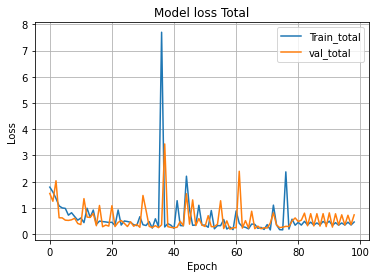

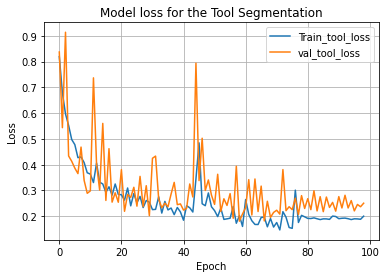

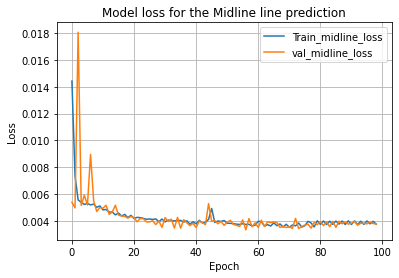

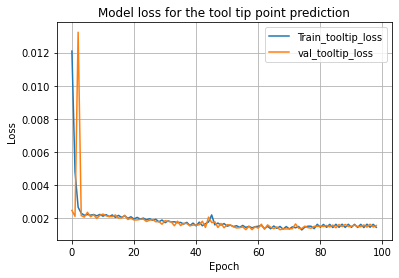

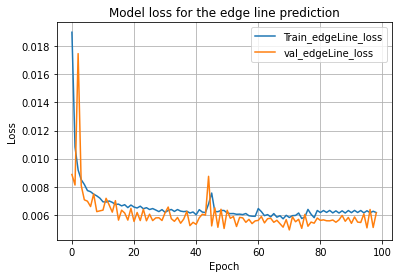

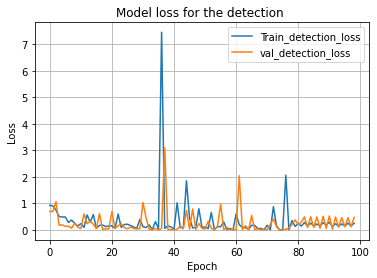

In [8]:
import pandas as pd 
logs = pd.read_csv('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/FullTraining/ModelLR1/full_testasval_nosplit_extradata_adaptiveLR.csv')
#logs = pd.read_csv('/home/mahmoud/Desktop/primitives/modelLR1extradata/training26extradata.csv')
#logs= pd.read_csv('/home/mahmoud/Desktop/primitives/LastTrainedModelLR1_80-20split_extradata/training27extradata20percenttest2.csv')
# # Plot training & validation loss values
plt.figure()
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.title('Model loss Total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_total','val_total'], loc='upper right')
plt.grid('on')
plt.show()


plt.figure()
plt.plot(logs['tool_loss'])
plt.plot(logs['val_tool_loss'])
plt.title('Model loss for the Tool Segmentation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_tool_loss', 'val_tool_loss'], loc='upper right')
plt.grid('on')
plt.show()


plt.figure()
plt.plot(logs['midline_loss'])
plt.plot(logs['val_midline_loss'])
plt.title('Model loss for the Midline line prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_midline_loss','val_midline_loss'], loc='upper right')
plt.grid('on')
plt.show()


plt.figure()
plt.plot(logs['tooltip_loss'])
plt.plot(logs['val_tooltip_loss'])
plt.title('Model loss for the tool tip point prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_tooltip_loss','val_tooltip_loss'], loc='upper right')
plt.grid('on')
plt.show()


plt.figure()
plt.plot(logs['edgeline_loss'])
plt.plot(logs['val_edgeline_loss'])
plt.title('Model loss for the edge line prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_edgeLine_loss','val_edgeLine_loss'], loc='upper right')
plt.grid('on')
plt.show()


plt.figure()
plt.plot(logs['detection_loss'])
plt.plot(logs['val_detection_loss'])
plt.title('Model loss for the detection ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_detection_loss','val_detection_loss'], loc='upper right')
plt.grid('on')
plt.show()